#**Getting Data**

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.82 MiB/s, done.
Updating files: 100% (13/13), done.


In [2]:
import os
os.listdir("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign") #dev stands for devolopment set same as validation set

['dev.txt', 'test.txt', 'train.txt']

In [3]:
# import zipfile

# zip_ref=zipfile.ZipFile("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.zip")
# zip_ref.extractall()
# zip_ref.close()

In [4]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"
file_path=[data_dir+"/"+file for file in os.listdir("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign")]
file_path

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [5]:
#file_path.pop(0)

In [6]:
# file_path.insert(0, "train.txt")
# file_path

In [7]:
def get_lines(file_path):
  with open(file_path,"r") as f:
    return f.readlines()

In [8]:
get_lines(file_path[0])[1]

'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n'

#**Preprocessing data**

In [9]:
def preprocess(file_path):
  abstracts=get_lines(file_path)
  abstract_line=""
  abstract_samples=[]

  for line in abstracts:
    if line.startswith("###"): #This indicates the begining of a new abstract
      abstract_id=line
      abstract_line=""
    elif line.startswith("\n"):
      abstract_sentence_split=abstract_line.splitlines()
      for abstract_sentence_no, abstract_sentence in enumerate(abstract_sentence_split):
        target_text_split=abstract_sentence.split("\t")
        line_data={}
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1]
        line_data["line_number"]=abstract_sentence_no
        line_data["total_lines"]=len(abstract_sentence_split)
        
        abstract_samples.append(line_data)
    else:
      abstract_line+=line

  return abstract_samples

In [10]:
%%time
train_samples=preprocess(file_path[0])
test_samples=preprocess(file_path[1])
validation_samples=preprocess(file_path[2])

CPU times: user 590 ms, sys: 123 ms, total: 713 ms
Wall time: 1.09 s


In [11]:
train_samples[:15]

[{'target': 'BACKGROUND',
  'text': 'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'It is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'OBJECTIVE',
  'text': 'We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 10},
 {'t

#**Visualising preprocessed data**

In [12]:
import pandas as pd

train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
validation_df=pd.DataFrame(validation_samples)

In [13]:
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,10
1,BACKGROUND,It is not clear whether these patients would b...,1,10
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,10
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,10
4,METHODS,Primary outcomes were improvement in quality o...,4,10
5,RESULTS,Sixty-five patients were randomized .,5,10
6,RESULTS,Fifty-nine patients started treatment ( @ rece...,6,10
7,RESULTS,Fifty-six patients took the full @ months of m...,7,10
8,RESULTS,"Between the voriconazole and placebo groups , ...",8,10
9,CONCLUSIONS,We were unable to show a beneficial effect of ...,9,10


In [14]:
train_df["target"].value_counts()

METHODS        9964
RESULTS        9841
CONCLUSIONS    4582
BACKGROUND     3449
OBJECTIVE      2376
Name: target, dtype: int64

In [15]:
classes=[]
for i in train_df["target"].value_counts().keys():
  classes.append(i)

classes.sort()
classes

['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

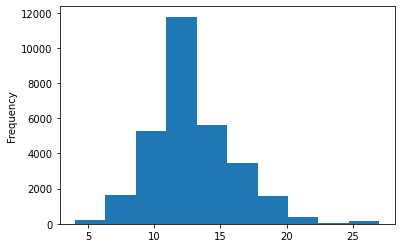

In [16]:
train_df["total_lines"].plot(kind="hist");

**One hot encode**

In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot_encode=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot_encode=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
validation_labels_one_hot_encode=one_hot_encoder.transform(validation_df["target"].to_numpy().reshape(-1,1))

In [18]:
train_labels_one_hot_encode

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

**Integer encode**

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
train_labels_encode=label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encode=label_encoder.transform(test_df["target"].to_numpy())
validation_labels_encode=label_encoder.transform(validation_df["target"].to_numpy())

In [20]:
train_labels_encode

array([0, 0, 3, ..., 4, 1, 1])

**Converting text in df to list**

In [21]:
train_text=train_df["text"].tolist()
test_text=test_df["text"].tolist()
validation_text=validation_df["text"].tolist()

train_text[:2]

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'It is not clear whether these patients would benefit from antifungal treatment .']

**Model_evaluation_metrics**

In [22]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def calculate_metrics(y_true, y_preds):
  model_results={"Accuracy": accuracy_score(y_true, y_preds),
                 "Precision": precision_score(y_true, y_preds, average="weighted"),
                 "Recall": recall_score(y_true, y_preds, average="weighted"),
                 "f1_score": f1_score(y_true, y_preds, average="weighted"),
                 }
  return model_results

#**Model_0**:NaiveBais

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([("tf_idf", TfidfVectorizer()),
                 ("clf", MultinomialNB())])

In [24]:
model_0.fit(train_text,train_labels_encode)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
model_0_score=model_0.score(validation_text, validation_labels_encode)
model_0_score

0.6764107976005332

In [26]:
y_preds=model_0.predict(validation_text)
y_preds

array([2, 2, 4, ..., 4, 4, 2])

In [27]:
model_0_results=calculate_metrics(validation_labels_encode, y_preds)
model_0_results

{'Accuracy': 0.6764107976005332,
 'Precision': 0.6805658878020778,
 'Recall': 0.6764107976005332,
 'f1_score': 0.6349298999118057}

#**Model_1**: CNN-1D

In [28]:
import tensorflow as tf
import numpy as np

In [29]:
sent_len=[len(sentence.split()) for sentence in train_text]
avg_sent_len=np.mean(sent_len)
avg_sent_len

26.42244803389382

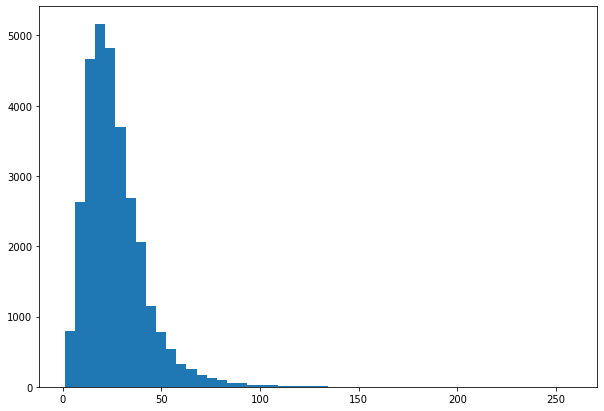

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.hist(sent_len, bins=50);

In [31]:
sent_len_95_percentile=int(np.percentile(sent_len, 95))
sent_len_95_percentile #this is the len of sentence which will cover 95% of the given text samples

55

**Word level tokenization**

In [32]:
max_vocab=100000
best_len=sent_len_95_percentile

In [33]:
text_vectorizer= tf.keras.layers.TextVectorization(max_tokens=max_vocab,
                                                   output_sequence_length= best_len)
text_vectorizer.adapt(train_text)

In [34]:
vocab_learnt=text_vectorizer.get_vocabulary()
print("vocab learnt: ",len(vocab_learnt))
print("most common 5 words: ",vocab_learnt[:5])
print("leastcommon 5 words: ",vocab_learnt[-5:])

vocab learnt:  25008
most common 5 words:  ['', '[UNK]', 'the', 'and', 'of']
leastcommon 5 words:  ['aas', 'aaraai', 'aale', 'aai', 'aado']


In [35]:
import random
target_text=random.choice(train_text)
print("text:\n",target_text)
print("\nafter tokenization:\n",text_vectorizer(target_text))

text:
 Our primary hypothesis is that , among African Americans with poorly controlled T@DM , patients randomized to the TIDES intervention will have significantly greater reduction in glycosylated hemoglobin A@c at @ months of follow-up compared to the usual-care group .

after tokenization:
 tf.Tensor(
[  252    59   916    20    29   111  1770  2990     7  2926   101  1294
    11    30     6     2 10763    37   109   100    40   175   191     5
  3900   693  1771    16    41     4   103    33     6     2  6288    13
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)


**Embedding**

In [36]:
embedding=tf.keras.layers.Embedding(input_dim=len(vocab_learnt),
                                    output_dim=128)

In [37]:
print("text:\n", target_text)
print("\nvectorised text's first word:\n",embedding(text_vectorizer(target_text))[0])

text:
 Our primary hypothesis is that , among African Americans with poorly controlled T@DM , patients randomized to the TIDES intervention will have significantly greater reduction in glycosylated hemoglobin A@c at @ months of follow-up compared to the usual-care group .

vectorised text's first word:
 tf.Tensor(
[-1.70706399e-02 -6.49695471e-03 -6.91910833e-03 -4.55271713e-02
 -2.85056476e-02 -3.50766666e-02  7.06219673e-03 -1.28322132e-02
  1.06977709e-02  1.38660520e-03 -1.55866034e-02  2.37290747e-02
 -3.14621553e-02  4.15052660e-02  4.46700566e-02 -1.46263465e-02
 -3.00850160e-02  1.27903260e-02 -3.87068279e-02 -1.82546303e-03
 -2.00894363e-02 -2.49496829e-02  3.59565951e-02 -9.52430815e-03
 -3.26606631e-02  2.55964510e-02 -4.12138924e-02  4.54544462e-02
  2.21126154e-03  3.76449116e-02 -8.82526487e-03  1.29100345e-02
  4.99448441e-02 -1.79119222e-02 -2.80898344e-02 -7.89440796e-03
  5.65617159e-03  2.89648436e-02  3.35588790e-02 -3.91019806e-02
 -1.28764883e-02 -2.30769273e-02  

#**Speeding up loading time**

In [38]:
train_text[:5]

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'It is not clear whether these patients would benefit from antifungal treatment .',
 'We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .']

In [39]:
train_data=tf.data.Dataset.from_tensor_slices((train_text,train_labels_one_hot_encode)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_data=tf.data.Dataset.from_tensor_slices((validation_text, validation_labels_one_hot_encode)).batch(32).prefetch(tf.data.AUTOTUNE)
test_data=tf.data.Dataset.from_tensor_slices((test_text, test_labels_one_hot_encode)).batch(32).prefetch(tf.data.AUTOTUNE)

In [40]:
for text_train, label_train in train_data.take(1):
  print(text_train, label_train)

tf.Tensor(
[b'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .'
 b'It is not clear whether these patients would benefit from antifungal treatment .'
 b'We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .'
 b'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .'
 b'Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .'
 b'Sixty-five patients were randomized .'
 b'Fifty-nine patients started treatment ( @ receiving voriconazole and @ re

In [41]:
inputs=tf.keras.layers.Input((1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)
outputs=tf.keras.layers.Dense(5, activation="softmax")(x)

model_1=tf.keras.Model(inputs, outputs)

In [42]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           3201024   
                                                                 
 conv1d (Conv1D)             (None, 53, 64)            24640     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [43]:
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1=model_1.fit(train_data,
                      #steps_per_epoch=int(0.1*len(train_data)),
                      epochs=5,
                      validation_steps=int(0.1*len(validation_data)),
                      validation_data=(validation_data))

Epoch 1/5
945/945 [==============================] - 16s 8ms/step - loss: 0.7493 - accuracy: 0.7217 - val_loss: 0.5846 - val_accuracy: 0.7855
Epoch 2/5
945/945 [==============================] - 6s 7ms/step - loss: 0.4142 - accuracy: 0.8530 - val_loss: 0.5863 - val_accuracy: 0.7869
Epoch 3/5
945/945 [==============================] - 7s 8ms/step - loss: 0.2305 - accuracy: 0.9275 - val_loss: 0.6520 - val_accuracy: 0.7795
Epoch 4/5
945/945 [==============================] - 7s 8ms/step - loss: 0.1067 - accuracy: 0.9732 - val_loss: 0.7464 - val_accuracy: 0.7754
Epoch 5/5
945/945 [==============================] - 8s 8ms/step - loss: 0.0459 - accuracy: 0.9910 - val_loss: 0.8381 - val_accuracy: 0.7715


In [44]:
model_1.evaluate(validation_data)

5627/5627 [==============================] - 17s 3ms/step - loss: 0.8532 - accuracy: 0.7677


[0.8531861901283264, 0.7676571607589722]

In [45]:
pred_probs=model_1.predict(validation_data)
pred_probs

5627/5627 [==============================] - 12s 2ms/step


array([[2.3120199e-03, 2.2285029e-02, 1.0035738e-02, 9.6512115e-01,
        2.4610141e-04],
       [1.7088632e-06, 1.0903586e-06, 9.9945086e-01, 6.7393347e-07,
        5.4569851e-04],
       [1.1487709e-04, 3.3333199e-03, 5.2016586e-01, 1.2697492e-02,
        4.6368843e-01],
       ...,
       [1.2761775e-04, 9.2557025e-01, 2.0395387e-03, 6.7503766e-05,
        7.2194964e-02],
       [6.7813389e-02, 9.2778569e-01, 4.3353673e-05, 1.4819370e-03,
        2.8755895e-03],
       [4.2013809e-02, 3.0252882e-04, 9.4597900e-01, 1.1704481e-02,
        2.3066232e-07]], dtype=float32)

In [46]:
y_preds=pred_probs.argmax(axis=1)
y_preds

array([3, 2, 2, ..., 1, 1, 2])

In [47]:
model_1_results=calculate_metrics(validation_labels_encode, y_preds)
model_1_results

{'Accuracy': 0.767657187291713,
 'Precision': 0.7678150438370275,
 'Recall': 0.767657187291713,
 'f1_score': 0.7660778180603898}

#**Model_2**: pre-trained embedding(TF)

In [48]:
USE_url="https://tfhub.dev/google/universal-sentence-encoder/4" #use stands for universal encoder

In [49]:
import tensorflow_hub as hub

use_layer=hub.KerasLayer(USE_url, trainable=True)

In [50]:
inputs=tf.keras.layers.Input([], dtype="string")
x=use_layer(inputs)
x=tf.keras.layers.Dense(64, activation="relu")(x)
outputs=tf.keras.layers.Dense(5, activation="softmax")(x)

model_2=tf.keras.Model(inputs,outputs)

In [51]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 256,830,981
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2=model_2.fit(train_data,
                      #steps_per_epoch=int(0.1*len(train_data)),
                      epochs=5,
                      validation_data=(validation_data),
                      validation_steps=int(0.1*len(validation_data)))

Epoch 1/5
945/945 [==============================] - 154s 156ms/step - loss: 0.6766 - accuracy: 0.7433 - val_loss: 0.5655 - val_accuracy: 0.7928
Epoch 2/5
945/945 [==============================] - 147s 156ms/step - loss: 0.2430 - accuracy: 0.9138 - val_loss: 0.6633 - val_accuracy: 0.7764
Epoch 3/5
945/945 [==============================] - 147s 156ms/step - loss: 0.0718 - accuracy: 0.9787 - val_loss: 0.8625 - val_accuracy: 0.7647
Epoch 4/5
945/945 [==============================] - 147s 156ms/step - loss: 0.0211 - accuracy: 0.9946 - val_loss: 0.9978 - val_accuracy: 0.7748
Epoch 5/5
945/945 [==============================] - 146s 155ms/step - loss: 0.0104 - accuracy: 0.9976 - val_loss: 1.0582 - val_accuracy: 0.7778


In [53]:
model_2.evaluate(validation_data)

5627/5627 [==============================] - 58s 10ms/step - loss: 1.0840 - accuracy: 0.7715


[1.0840091705322266, 0.7714563608169556]

In [54]:
pred_probs=model_2.predict(validation_data)
pred_probs

5627/5627 [==============================] - 55s 10ms/step


array([[1.6719148e-03, 4.6912595e-04, 5.0279731e-04, 9.9735439e-01,
        1.7287416e-06],
       [4.1304702e-05, 8.3286432e-05, 5.3620506e-02, 6.7825999e-06,
        9.4624811e-01],
       [2.0169684e-05, 8.0210833e-05, 9.9967289e-01, 9.6852993e-05,
        1.2988276e-04],
       ...,
       [3.0859979e-04, 9.9933380e-01, 1.0953982e-04, 1.2435402e-04,
        1.2374713e-04],
       [1.2732139e-04, 9.9950194e-01, 1.2891358e-05, 9.0166672e-05,
        2.6759892e-04],
       [1.5318836e-03, 2.6668804e-02, 1.1059761e-02, 9.6047366e-01,
        2.6587848e-04]], dtype=float32)

In [55]:
y_preds=pred_probs.argmax(axis=1)
y_preds

array([3, 4, 2, ..., 1, 1, 3])

In [56]:
model_2_results=calculate_metrics(validation_labels_encode, y_preds)
model_2_results

{'Accuracy': 0.7714563430348811,
 'Precision': 0.7795041226377141,
 'Recall': 0.7714563430348811,
 'f1_score': 0.7727648494642387}

#**Model_3**: CNN-1D + character level tokenization

**Character level tokenization**

In [57]:
list(target_text), " ".join(list(target_text)), target_text

(['O',
  'u',
  'r',
  ' ',
  'p',
  'r',
  'i',
  'm',
  'a',
  'r',
  'y',
  ' ',
  'h',
  'y',
  'p',
  'o',
  't',
  'h',
  'e',
  's',
  'i',
  's',
  ' ',
  'i',
  's',
  ' ',
  't',
  'h',
  'a',
  't',
  ' ',
  ',',
  ' ',
  'a',
  'm',
  'o',
  'n',
  'g',
  ' ',
  'A',
  'f',
  'r',
  'i',
  'c',
  'a',
  'n',
  ' ',
  'A',
  'm',
  'e',
  'r',
  'i',
  'c',
  'a',
  'n',
  's',
  ' ',
  'w',
  'i',
  't',
  'h',
  ' ',
  'p',
  'o',
  'o',
  'r',
  'l',
  'y',
  ' ',
  'c',
  'o',
  'n',
  't',
  'r',
  'o',
  'l',
  'l',
  'e',
  'd',
  ' ',
  'T',
  '@',
  'D',
  'M',
  ' ',
  ',',
  ' ',
  'p',
  'a',
  't',
  'i',
  'e',
  'n',
  't',
  's',
  ' ',
  'r',
  'a',
  'n',
  'd',
  'o',
  'm',
  'i',
  'z',
  'e',
  'd',
  ' ',
  't',
  'o',
  ' ',
  't',
  'h',
  'e',
  ' ',
  'T',
  'I',
  'D',
  'E',
  'S',
  ' ',
  'i',
  'n',
  't',
  'e',
  'r',
  'v',
  'e',
  'n',
  't',
  'i',
  'o',
  'n',
  ' ',
  'w',
  'i',
  'l',
  'l',
  ' ',
  'h',
  'a',
  'v',
  'e',
  ' ',

In [58]:
def split_char(text):
  return " ".join(list(text))

In [59]:
split_char(target_text)

'O u r   p r i m a r y   h y p o t h e s i s   i s   t h a t   ,   a m o n g   A f r i c a n   A m e r i c a n s   w i t h   p o o r l y   c o n t r o l l e d   T @ D M   ,   p a t i e n t s   r a n d o m i z e d   t o   t h e   T I D E S   i n t e r v e n t i o n   w i l l   h a v e   s i g n i f i c a n t l y   g r e a t e r   r e d u c t i o n   i n   g l y c o s y l a t e d   h e m o g l o b i n   A @ c   a t   @   m o n t h s   o f   f o l l o w - u p   c o m p a r e d   t o   t h e   u s u a l - c a r e   g r o u p   .'

In [60]:
train_text[:2]

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'It is not clear whether these patients would benefit from antifungal treatment .']

In [61]:
train_char=[split_char(text)for text in train_text]
test_char=[split_char(text)for text in test_text]
validation_char=[split_char(text)for text in validation_text]

train_char[:2]

['I g E   s e n s i t i z a t i o n   t o   A s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'I t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .']

In [62]:
char_len=[len(sentence) for sentence in train_text]
mean_char_len= np.mean(char_len)

mean_char_len

149.19111611280286

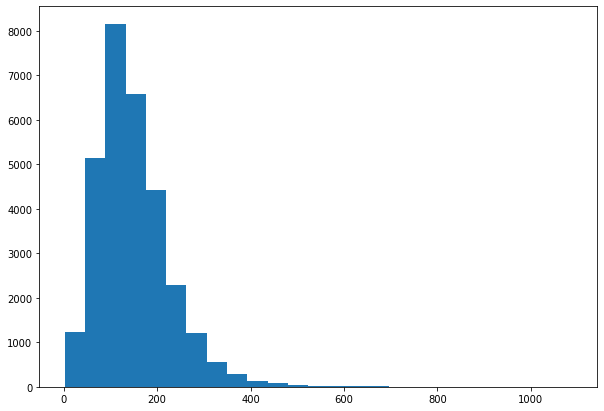

In [63]:
plt.figure(figsize=(10,7))
plt.hist(char_len, bins=25);

In [64]:
sent_len_95_percentile=int(np.percentile(char_len, 95))
sent_len_95_percentile

290

In [65]:
import string

char_vocab= string.ascii_lowercase + string.digits + string.punctuation
len(char_vocab), char_vocab

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [66]:
max_char_vocab=len(char_vocab)+2 #For " " and oov
max_length=sent_len_95_percentile

In [67]:
char_vectorizer=tf.keras.layers.TextVectorization(max_tokens=max_char_vocab,
                                                  output_sequence_length=max_length)

char_vectorizer.adapt(train_char)

In [68]:
char_vocab_learnt=char_vectorizer.get_vocabulary()
print(f"Text:\n{target_text}\n\nUpdated text:{split_char(target_text)}\n\nAfter character tokenization:\n{char_vectorizer(split_char(target_text))}")

Text:
Our primary hypothesis is that , among African Americans with poorly controlled T@DM , patients randomized to the TIDES intervention will have significantly greater reduction in glycosylated hemoglobin A@c at @ months of follow-up compared to the usual-care group .

Updated text:O u r   p r i m a r y   h y p o t h e s i s   i s   t h a t   ,   a m o n g   A f r i c a n   A m e r i c a n s   w i t h   p o o r l y   c o n t r o l l e d   T @ D M   ,   p a t i e n t s   r a n d o m i z e d   t o   t h e   T I D E S   i n t e r v e n t i o n   w i l l   h a v e   s i g n i f i c a n t l y   g r e a t e r   r e d u c t i o n   i n   g l y c o s y l a t e d   h e m o g l o b i n   A @ c   a t   @   m o n t h s   o f   f o l l o w - u p   c o m p a r e d   t o   t h e   u s u a l - c a r e   g r o u p   .

After character tokenization:
[ 7 16  8 14  8  4 15  5  8 19 13 19 14  7  3 13  2  9  4  9  4  9  3 13
  5  3  5 15  7  6 18  5 17  8  4 11  5  6  5 15  2  8  4 11  5  6  9 20
  4  3 

In [69]:
print(char_vocab_learnt)
print("len of learnt vocab:", len(char_vocab_learnt))
print("5 most common words:", char_vocab_learnt[:5])
print("5 least common words:", char_vocab_learnt[-5:])

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']
len of learnt vocab: 28
5 most common words: ['', '[UNK]', 'e', 't', 'i']
5 least common words: ['k', 'x', 'z', 'q', 'j']


**Character level embedding**

In [70]:
char_embedding= tf.keras.layers.Embedding(input_dim=max_char_vocab,
                                          output_dim=32)

In [71]:
print("Text:\n",target_text)
print("\n\n Updated text:\n",split_char(target_text))
print("\n\n Char tokenisation:\n",char_vectorizer(split_char(target_text)))
print("\n\n Embedding:\n",char_embedding(char_vectorizer(split_char(target_text))))
print("\n\nShape: ",char_embedding(char_vectorizer(split_char(target_text))).shape)

Text:
 Our primary hypothesis is that , among African Americans with poorly controlled T@DM , patients randomized to the TIDES intervention will have significantly greater reduction in glycosylated hemoglobin A@c at @ months of follow-up compared to the usual-care group .


 Updated text:
 O u r   p r i m a r y   h y p o t h e s i s   i s   t h a t   ,   a m o n g   A f r i c a n   A m e r i c a n s   w i t h   p o o r l y   c o n t r o l l e d   T @ D M   ,   p a t i e n t s   r a n d o m i z e d   t o   t h e   T I D E S   i n t e r v e n t i o n   w i l l   h a v e   s i g n i f i c a n t l y   g r e a t e r   r e d u c t i o n   i n   g l y c o s y l a t e d   h e m o g l o b i n   A @ c   a t   @   m o n t h s   o f   f o l l o w - u p   c o m p a r e d   t o   t h e   u s u a l - c a r e   g r o u p   .


 Char tokenisation:
 tf.Tensor(
[ 7 16  8 14  8  4 15  5  8 19 13 19 14  7  3 13  2  9  4  9  4  9  3 13
  5  3  5 15  7  6 18  5 17  8  4 11  5  6  5 15  2  8  4 11  5  6  9 20

In [72]:
inputs=tf.keras.layers.Input((1,), dtype="string")
x=char_vectorizer(inputs)
x=char_embedding(x)
x=tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)
x=tf.keras.layers.Dense(64, activation="relu")(x)
outputs=tf.keras.layers.Dense(5, activation="softmax")(x)

model_3=tf.keras.Model(inputs,outputs)

In [73]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 290, 32)           2240      
                                                                 
 conv1d_1 (Conv1D)           (None, 288, 64)           6208      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                4160

In [74]:
train_data_char=tf.data.Dataset.from_tensor_slices((train_char,train_labels_one_hot_encode)).prefetch(tf.data.AUTOTUNE).batch(32)
test_data_char=tf.data.Dataset.from_tensor_slices((test_char,test_labels_one_hot_encode)).prefetch(tf.data.AUTOTUNE).batch(32)
validation_data_char=tf.data.Dataset.from_tensor_slices((validation_char,validation_labels_one_hot_encode)).prefetch(tf.data.AUTOTUNE).batch(32)

train_data_char

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [75]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.fit(train_data_char,
            epochs=5,
            #steps_per_epoch=int(0.1*len(train_data_char)),
            validation_data=(validation_data_char),
            validation_steps=int(0.1*len(validation_data_char)))

Epoch 1/5
945/945 [==============================] - 7s 7ms/step - loss: 1.1658 - accuracy: 0.5225 - val_loss: 1.0276 - val_accuracy: 0.5700
Epoch 2/5
945/945 [==============================] - 6s 6ms/step - loss: 0.9492 - accuracy: 0.6126 - val_loss: 0.9691 - val_accuracy: 0.6007
Epoch 3/5
945/945 [==============================] - 6s 7ms/step - loss: 0.8913 - accuracy: 0.6422 - val_loss: 0.9482 - val_accuracy: 0.6126
Epoch 4/5
945/945 [==============================] - 6s 6ms/step - loss: 0.8565 - accuracy: 0.6590 - val_loss: 0.9283 - val_accuracy: 0.6244
Epoch 5/5
945/945 [==============================] - 6s 7ms/step - loss: 0.8355 - accuracy: 0.6679 - val_loss: 0.9182 - val_accuracy: 0.6328


In [76]:
model_3.evaluate(validation_data_char)

5627/5627 [==============================] - 20s 3ms/step - loss: 0.9166 - accuracy: 0.6312


[0.916622519493103, 0.6311874985694885]

In [77]:
pred_probs=model_3.predict(validation_data_char)
pred_probs

5627/5627 [==============================] - 13s 2ms/step


array([[0.2668131 , 0.4318575 , 0.0083282 , 0.28588766, 0.00711362],
       [0.01016905, 0.00641677, 0.9308258 , 0.00405739, 0.04853102],
       [0.06375416, 0.55298465, 0.07840965, 0.01860441, 0.2862471 ],
       ...,
       [0.36156726, 0.42377862, 0.0055925 , 0.17137305, 0.03768853],
       [0.1883206 , 0.5666737 , 0.01651965, 0.1802677 , 0.04821828],
       [0.35544324, 0.24976864, 0.18952335, 0.13178852, 0.07347621]],
      dtype=float32)

In [78]:
y_preds=pred_probs.argmax(axis=1)
y_preds

array([1, 2, 1, ..., 1, 1, 0])

In [79]:
model_3_results=calculate_metrics(validation_labels_encode, y_preds)
model_3_results

{'Accuracy': 0.6311875138858032,
 'Precision': 0.6574697901204577,
 'Recall': 0.6311875138858032,
 'f1_score': 0.6305673204063331}

#**Model_4**:word+character level tokenization

In [80]:
char_embedding_2= tf.keras.layers.Embedding(input_dim=max_char_vocab,
                                          output_dim=128)

In [81]:

#1 word level_tokenization
input_token=tf.keras.layers.Input([],dtype="string")
token_embedding=use_layer(input_token)
output_token_embedding=tf.keras.layers.Dense(64, activation="relu")(token_embedding)

word_model= tf.keras.Model(input_token, output_token_embedding)

#2 char level tokenization
input_char=tf.keras.layers.Input((1,), dtype="string")
x=char_vectorizer(input_char)
x=char_embedding_2(x)
output_char=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)

char_model=tf.keras.Model(input_char, output_char)

#3 concatenate
concatenate_layer=tf.keras.layers.Concatenate()([word_model.output, char_model.output])

#4 adding final layers
dropout=tf.keras.layers.Dropout(0.5)(concatenate_layer)
dense=tf.keras.layers.Dense(64, activation="relu")(dropout)
final_dropout=tf.keras.layers.Dropout(0.5)(dense)
outputs=tf.keras.layers.Dense(5, activation="softmax")(final_dropout)

model_4=tf.keras.Model(inputs=[word_model.input, char_model.input],
                       outputs=outputs)

In [82]:
char_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 290, 128)          8960      
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
Total params: 50,176
Trainable params: 50,176
Non-trainable params: 0
_________________________________________________________________


In [83]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_4[0][0]']          

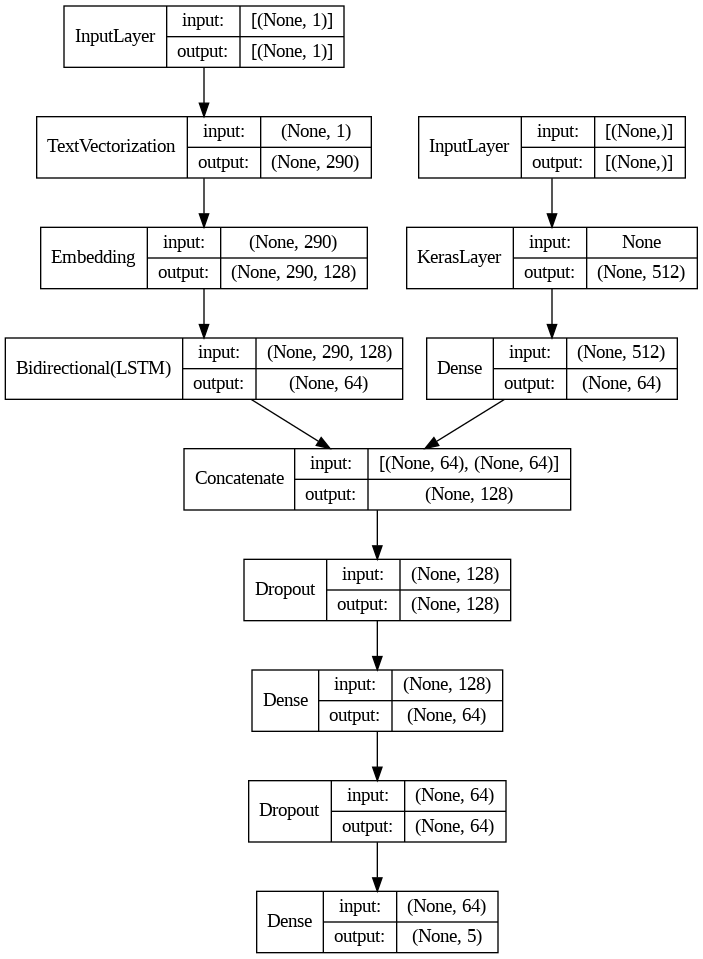

In [84]:
tf.keras.utils.plot_model(model_4, show_shapes=True, show_layer_names=False)

**Getting the input ready**

In [85]:
train_data_char_inputs=tf.data.Dataset.from_tensor_slices((train_text, train_char))
train_data_char_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot_encode)
train_dataset=tf.data.Dataset.zip((train_data_char_inputs, train_data_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [86]:
test_data_char_inputs=tf.data.Dataset.from_tensor_slices((test_text, test_char))
test_data_char_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot_encode)
test_dataset=tf.data.Dataset.zip((test_data_char_inputs, test_data_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [87]:
validation_data_char_inputs=tf.data.Dataset.from_tensor_slices((validation_text, validation_char))
validation_data_char_labels=tf.data.Dataset.from_tensor_slices(validation_labels_one_hot_encode)
validation_dataset=tf.data.Dataset.zip((validation_data_char_inputs, validation_data_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_4=model_4.fit(train_dataset,
                      #steps_per_epoch=int(.1*len(train_dataset)),
                      epochs=5,
                      validation_data=(validation_dataset),
                      validation_steps=int(0.1*len(validation_data)))

Epoch 1/5
945/945 [==============================] - 185s 188ms/step - loss: 0.0900 - accuracy: 0.9790 - val_loss: 1.6171 - val_accuracy: 0.7733
Epoch 2/5
945/945 [==============================] - 175s 186ms/step - loss: 0.0229 - accuracy: 0.9957 - val_loss: 1.6677 - val_accuracy: 0.7639
Epoch 3/5
945/945 [==============================] - 176s 186ms/step - loss: 0.0177 - accuracy: 0.9967 - val_loss: 1.9241 - val_accuracy: 0.7710
Epoch 4/5
945/945 [==============================] - 176s 186ms/step - loss: 0.0136 - accuracy: 0.9975 - val_loss: 1.9618 - val_accuracy: 0.7799
Epoch 5/5
945/945 [==============================] - 176s 186ms/step - loss: 0.0141 - accuracy: 0.9972 - val_loss: 2.0153 - val_accuracy: 0.7624


In [89]:
model_4.evaluate(validation_dataset)

5627/5627 [==============================] - 123s 22ms/step - loss: 2.0138 - accuracy: 0.7599


[2.0137600898742676, 0.7599477767944336]

In [90]:
pred_probs=model_4.predict(validation_dataset)
pred_probs

5627/5627 [==============================] - 116s 21ms/step


array([[2.40158073e-07, 9.30867614e-08, 4.20109032e-08, 9.99999642e-01,
        2.28783281e-09],
       [1.59171395e-05, 1.33180190e-04, 2.69149482e-01, 1.47855408e-05,
        7.30686605e-01],
       [1.50830209e-10, 1.55714428e-08, 9.99999881e-01, 4.98210850e-09,
        1.71702368e-07],
       ...,
       [4.37614835e-06, 9.99979496e-01, 3.56957980e-06, 2.60308241e-07,
        1.22939455e-05],
       [3.47402874e-07, 9.99999166e-01, 6.83256616e-08, 3.30151706e-09,
        4.04900902e-07],
       [3.87307091e-06, 1.01992350e-06, 1.56682597e-06, 9.99993443e-01,
        9.73492007e-08]], dtype=float32)

In [91]:
y_preds=pred_probs.argmax(axis=1)

In [92]:
model_4_results=calculate_metrics(validation_labels_encode, y_preds)
model_4_results

{'Accuracy': 0.7599477893801377,
 'Precision': 0.7664356467088728,
 'Recall': 0.7599477893801377,
 'f1_score': 0.7601112135742599}

#**Model_5**: word_embedding + character embedding + positional embedding

**Positional embediing**

>Line_number

In [93]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,10
1,BACKGROUND,It is not clear whether these patients would b...,1,10
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,10
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,10
4,METHODS,Primary outcomes were improvement in quality o...,4,10


In [94]:
train_df["line_number"].value_counts()

0     2500
1     2500
2     2500
3     2500
4     2497
5     2488
6     2461
7     2384
8     2247
9     2032
10    1699
11    1358
12    1001
13     713
14     494
15     323
16     203
17     112
18      75
19      50
20      27
21      18
22      10
23       7
24       7
25       4
26       2
Name: line_number, dtype: int64

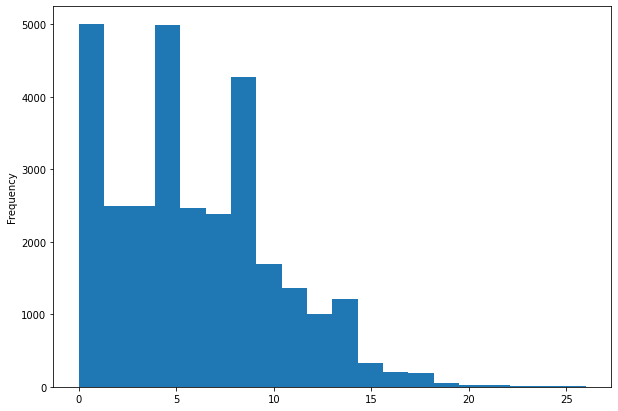

In [95]:
train_df["line_number"].plot(kind="hist", figsize=(10,7), bins=20);

In [96]:
line_number_95_percentile=np.percentile(train_df["line_number"], 95)
line_number_95_percentile

13.0

In [97]:
#we are here using one hot encode so that our model does not misinterpret "2" as 2*1 but rather as a different value

train_line_number_one_hot_encode=tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_95_percentile)
test_line_number_one_hot_encode=tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_95_percentile)
validation_line_number_one_hot_encode=tf.one_hot(validation_df["line_number"].to_numpy(), depth=line_number_95_percentile)

train_line_number_one_hot_encode

<tf.Tensor: shape=(30212, 13), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

>Total_line

In [98]:
train_df["total_lines"].value_counts()

12    4284
11    3751
13    3744
10    3330
14    3066
15    2565
9     1935
16    1920
17    1547
8     1096
18     666
7      539
19     475
20     460
21     189
22     176
6      162
25      75
23      69
27      54
26      52
5       45
4       12
Name: total_lines, dtype: int64

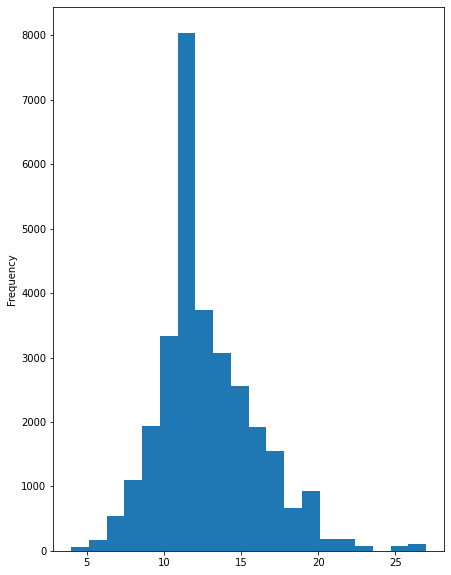

In [99]:
train_df["total_lines"].plot(kind="hist", figsize=(7,10), bins=20);

In [100]:
total_lines_95_percentile=np.percentile(train_df["total_lines"], 95)
total_lines_95_percentile

19.0

In [101]:
train_total_line_one_hot_encode= tf.one_hot(train_df["total_lines"].to_numpy(), depth=total_lines_95_percentile)
test_total_line_one_hot_encode= tf.one_hot(test_df["total_lines"].to_numpy(), depth=total_lines_95_percentile)
validation_total_line_one_hot_encode=tf.one_hot(validation_df["total_lines"].to_numpy(), depth= total_lines_95_percentile)

train_total_line_one_hot_encode[0]

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>

In [102]:
char_embedding_3= tf.keras.layers.Embedding(input_dim=max_char_vocab,
                                          output_dim=128)

In [103]:
# 1 word_tokenization
input_word=tf.keras.layers.Input(shape=[], dtype="string")
word_embeddings=use_layer(input_word)
output_word=tf.keras.layers.Dense(64, activation="relu")(word_embeddings)

model_word=tf.keras.Model(input_word, output_word)

#2 char_tokenization
input_char=tf.keras.layers.Input(shape=(1,), dtype="string")
char_vectors=char_vectorizer(input_char)
char_embeddings=char_embedding_3(char_vectors)
output_char=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(char_embeddings)

model_char=tf.keras.Model(input_char, output_char)

#3 line_number
input_line_number=tf.keras.layers.Input(shape=(13,), dtype=tf.int32)
output_line_number=tf.keras.layers.Dense(64, activation="relu")(input_line_number)

model_line_number=tf.keras.Model(input_line_number, output_line_number)

#4 total_line
input_total_line=tf.keras.layers.Input(shape=(19,), dtype=tf.int32)
output_total_line=tf.keras.layers.Dense(64, activation="relu")(input_total_line)

model_total_line=tf.keras.Model(input_total_line, output_total_line)

#5 concatenate word_model and char_model
concatenate_word_char=tf.keras.layers.Concatenate()([model_word.output, model_char.output])
z=tf.keras.layers.Dense(64, activation="relu")(concatenate_word_char)
z=tf.keras.layers.Dropout(0.5)(z)

#6 form the tribrid
concatenate_pos_word_char=tf.keras.layers.Concatenate()([model_line_number.output, model_total_line.output, z])

#7 add the classification head
output=tf.keras.layers.Dense(5, activation="softmax")(concatenate_pos_word_char)

#8 final model_5
model_5=tf.keras.Model(inputs=[model_line_number.input,
                               model_total_line.input,
                               model_word.input,
                               model_char.input],
                       outputs=output)

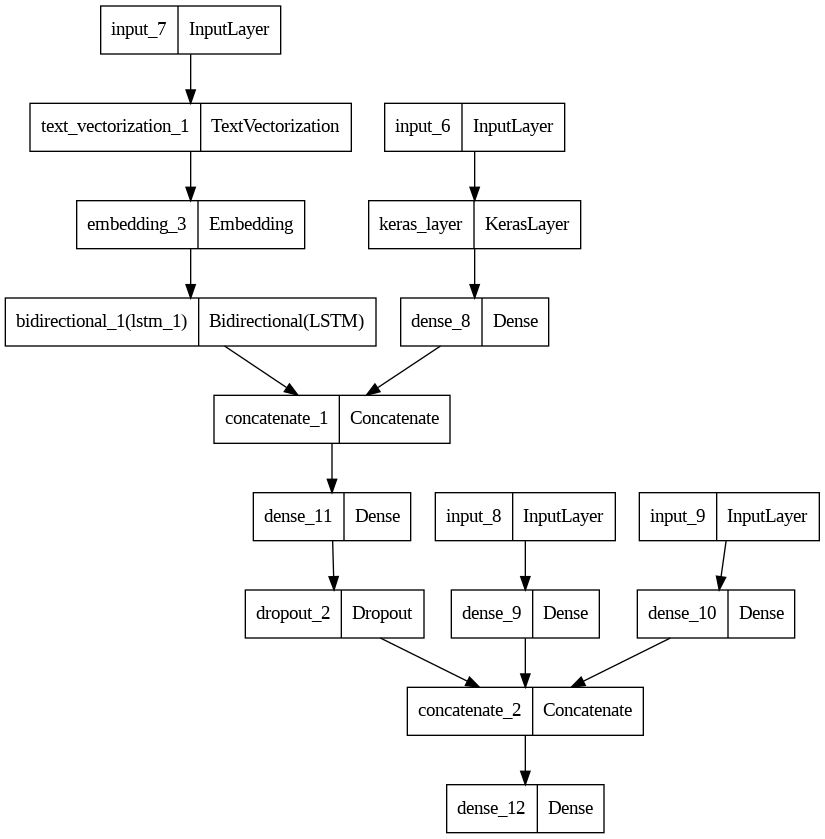

In [104]:
tf.keras.utils.plot_model(model_5)

**label smoothing**: it helps to prevent overfitting, if our model is highly confident on one class the other classes maybe be ignored and so the learning might not be very efficient.

ex: [0,0,1,0,0] #might not learn efficently

label smoothing takes in the highest prob and distributes small amount of it between other classes to aid learning patterns.

[.01,.01,0.96,.01,0.1]

In [105]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

**creating dataset**

In [106]:
train_data_tribrid=tf.data.Dataset.from_tensor_slices((train_line_number_one_hot_encode, train_total_line_one_hot_encode,
                                                       train_text, train_char))
train_data_label_tribrid=tf.data.Dataset.from_tensor_slices((train_labels_one_hot_encode))
train_dataset_tribrid=tf.data.Dataset.zip((train_data_tribrid, train_data_label_tribrid)).batch(32).prefetch(tf.data.AUTOTUNE)

test_data_tribrid=tf.data.Dataset.from_tensor_slices((test_line_number_one_hot_encode, test_total_line_one_hot_encode,
                                                       test_text, test_char))
test_data_label_tribrid=tf.data.Dataset.from_tensor_slices((test_labels_one_hot_encode))
test_dataset_tribrid=tf.data.Dataset.zip((test_data_tribrid, test_data_label_tribrid)).batch(32).prefetch(tf.data.AUTOTUNE)

validation_data_tribrid=tf.data.Dataset.from_tensor_slices((validation_line_number_one_hot_encode, validation_total_line_one_hot_encode,
                                                       validation_text, validation_char))
validation_data_label_tribrid=tf.data.Dataset.from_tensor_slices((validation_labels_one_hot_encode))
validation_dataset_tribrid=tf.data.Dataset.zip((validation_data_tribrid, validation_data_label_tribrid)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_tribrid

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [107]:
history_5=model_5.fit(train_dataset_tribrid,
                      epochs=5,
                      #steps_per_epoch=int(.1*len(train_dataset_tribrid)),
                      validation_data=(validation_dataset_tribrid),
                      validation_steps=int(.1*len(validation_dataset_tribrid)))

Epoch 1/5
945/945 [==============================] - 185s 189ms/step - loss: 0.7283 - accuracy: 0.9863 - val_loss: 1.0627 - val_accuracy: 0.7578
Epoch 2/5
945/945 [==============================] - 177s 187ms/step - loss: 0.7027 - accuracy: 0.9948 - val_loss: 1.0060 - val_accuracy: 0.7979
Epoch 3/5
945/945 [==============================] - 177s 187ms/step - loss: 0.7062 - accuracy: 0.9910 - val_loss: 0.9974 - val_accuracy: 0.7948
Epoch 4/5
945/945 [==============================] - 177s 187ms/step - loss: 0.7017 - accuracy: 0.9932 - val_loss: 1.0080 - val_accuracy: 0.7904
Epoch 5/5
945/945 [==============================] - 177s 187ms/step - loss: 0.6989 - accuracy: 0.9949 - val_loss: 0.9806 - val_accuracy: 0.8038


In [108]:
model_5.evaluate(validation_dataset_tribrid)

5627/5627 [==============================] - 123s 22ms/step - loss: 0.9830 - accuracy: 0.8016


[0.9830226302146912, 0.8015885353088379]

In [109]:
pred_probs=model_5.predict(validation_dataset_tribrid)
pred_probs

5627/5627 [==============================] - 118s 21ms/step


array([[0.059694  , 0.04530194, 0.03808637, 0.81534004, 0.04157759],
       [0.12033495, 0.0392026 , 0.29126617, 0.10008165, 0.4491146 ],
       [0.05159262, 0.02713483, 0.8438325 , 0.04785613, 0.02958388],
       ...,
       [0.04401546, 0.8298576 , 0.04141561, 0.03972021, 0.04499113],
       [0.04749466, 0.8250151 , 0.04194601, 0.03805397, 0.04749019],
       [0.06719656, 0.35041174, 0.07114955, 0.32153776, 0.18970443]],
      dtype=float32)

In [110]:
y_preds=pred_probs.argmax(axis=1)
y_preds

array([3, 4, 2, ..., 1, 1, 1])

In [111]:
model_5_results=calculate_metrics(validation_labels_encode, y_preds)
model_5_results

{'Accuracy': 0.8015885358809154,
 'Precision': 0.8000260255218261,
 'Recall': 0.8015885358809154,
 'f1_score': 0.7996224910417277}

#**Experiment_1**: Model_1+pos embedding

In [112]:
embedding_2=tf.keras.layers.Embedding(input_dim= len(vocab_learnt),
                                      output_dim=128)

In [113]:
#1 custom word embedding
input_word=tf.keras.layers.Input((1,), dtype="string")
text_vec=text_vectorizer(input_word)
embedding_layer=embedding_2(text_vec)
output_word=tf.keras.layers.LSTM(64)(embedding_layer)

model_custom_word=tf.keras.Model(input_word, output_word)

#2 pos embedding
model_line_number_2=tf.keras.models.clone_model(model_line_number)

model_total_line_2=tf.keras.models.clone_model(model_total_line)

#3 concatenate pos
concatenate_pos=tf.keras.layers.Concatenate()([model_line_number_2.output, model_total_line_2.output])

#4 concatenate custom_word+pos
concatenate_custom_pos=tf.keras.layers.Concatenate()([model_custom_word.output, concatenate_pos])

#5 classification_head
z=tf.keras.layers.Dense(64, activation="relu")(concatenate_custom_pos)
output=tf.keras.layers.Dense(5, activation="softmax")(z)

#6 model_exp_1
model_exp_1=tf.keras.Model(inputs=[model_custom_word.input, model_line_number_2.input, model_total_line_2.input],
                           outputs=output)

model_exp_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [114]:
model_exp_1.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['input_10[0][0]']               
 ization)                                                                                         
                                                                                                  
 input_8 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 19)]         0           []                        

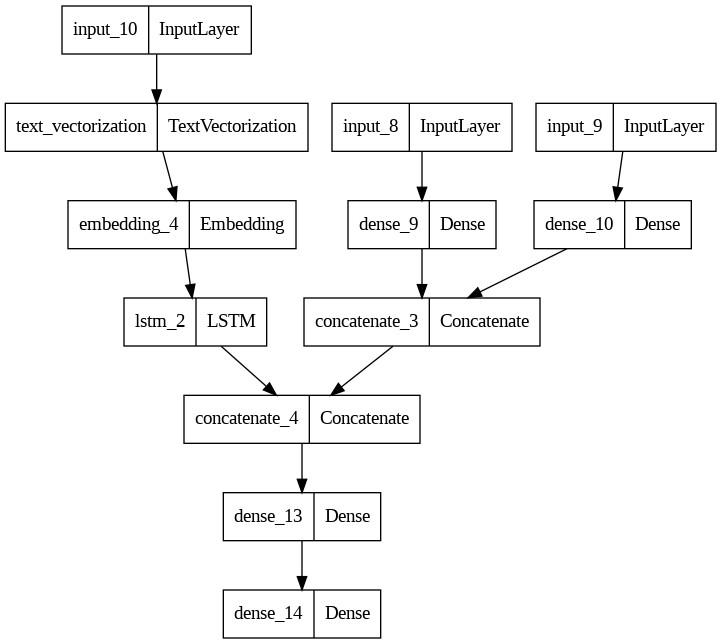

In [115]:
tf.keras.utils.plot_model(model_exp_1)

In [116]:
train_exp_1=tf.data.Dataset.from_tensor_slices((train_text, train_line_number_one_hot_encode, train_total_line_one_hot_encode))
train_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot_encode))
train_dataset_exp_1=tf.data.Dataset.zip((train_exp_1, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_exp_1=tf.data.Dataset.from_tensor_slices((test_text, test_line_number_one_hot_encode, test_total_line_one_hot_encode))
test_labels=tf.data.Dataset.from_tensor_slices((test_labels_one_hot_encode))
test_dataset_exp_1=tf.data.Dataset.zip((test_exp_1, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

validation_exp_1=tf.data.Dataset.from_tensor_slices((validation_text, validation_line_number_one_hot_encode, validation_total_line_one_hot_encode))
validation_labels=tf.data.Dataset.from_tensor_slices((validation_labels_one_hot_encode))
validation_dataset_exp_1=tf.data.Dataset.zip((validation_exp_1, validation_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_exp_1

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [117]:
history_exp_1=model_exp_1.fit(train_dataset_exp_1,
                              #steps_per_epoch=int(.1*len(train_dataset_exp_1)),
                              validation_data=(validation_dataset_exp_1),
                              epochs=5,
                              validation_steps=int(.1*len(validation_dataset_exp_1)))

Epoch 1/5
945/945 [==============================] - 11s 10ms/step - loss: 0.9067 - accuracy: 0.6181 - val_loss: 0.7955 - val_accuracy: 0.6654
Epoch 2/5
945/945 [==============================] - 9s 10ms/step - loss: 0.7624 - accuracy: 0.6810 - val_loss: 0.8159 - val_accuracy: 0.6634
Epoch 3/5
945/945 [==============================] - 11s 11ms/step - loss: 0.6913 - accuracy: 0.7080 - val_loss: 0.7267 - val_accuracy: 0.6955
Epoch 4/5
945/945 [==============================] - 9s 10ms/step - loss: 0.6821 - accuracy: 0.7129 - val_loss: 0.7045 - val_accuracy: 0.7043
Epoch 5/5
945/945 [==============================] - 9s 10ms/step - loss: 0.6667 - accuracy: 0.7234 - val_loss: 0.6980 - val_accuracy: 0.7066


In [118]:
model_exp_1.evaluate(validation_dataset_exp_1)

5627/5627 [==============================] - 26s 5ms/step - loss: 0.6900 - accuracy: 0.7117


[0.6899681687355042, 0.7116696238517761]

In [119]:
pred_probs=model_exp_1.predict(validation_dataset_exp_1)
pred_probs

5627/5627 [==============================] - 20s 3ms/step


array([[5.35756886e-01, 8.76935446e-05, 9.73327027e-04, 4.63150710e-01,
        3.13929922e-05],
       [1.75380677e-01, 4.69852239e-05, 6.06770635e-01, 2.03847617e-01,
        1.39540536e-02],
       [3.87290806e-01, 1.05824838e-04, 2.70041823e-01, 3.36062342e-01,
        6.49928022e-03],
       ...,
       [6.22758716e-02, 7.89487302e-01, 2.82941516e-02, 1.21058165e-05,
        1.19930618e-01],
       [1.40493307e-02, 7.28796721e-01, 7.13204592e-03, 3.48570893e-06,
        2.50018388e-01],
       [9.89059508e-02, 8.91139507e-01, 3.30686802e-03, 1.58036128e-05,
        6.63192943e-03]], dtype=float32)

In [120]:
y_preds=pred_probs.argmax(axis=1)
y_preds

array([0, 2, 0, ..., 1, 1, 1])

In [121]:
model_exp_1_results=calculate_metrics(validation_labels_encode, y_preds)
model_exp_1_results

{'Accuracy': 0.7116696289713397,
 'Precision': 0.7062390478859142,
 'Recall': 0.7116696289713397,
 'f1_score': 0.7043062969083594}

#**Experiment_2**:custom+pretrained+pos embedding

In [122]:
embedding_3=tf.keras.layers.Embedding(input_dim= len(vocab_learnt),
                                      output_dim=128)
char_embedding_4= tf.keras.layers.Embedding(input_dim=max_char_vocab,
                                          output_dim=128)

In [123]:
#1 custom word embedding
input_word=tf.keras.layers.Input((1,), dtype="string")
text_vector=text_vectorizer(input_word)
embedding_layer=embedding_3(text_vector)
output_word=tf.keras.layers.LSTM(64)(embedding_layer)

model_custom_word=tf.keras.Model(input_word, output_word)

#2 pre_trained embedding
model_pre_trained_word=tf.keras.models.clone_model(model_word)

#3 char_tokenization
input_char=tf.keras.layers.Input((1,), dtype="string")
x=char_vectorizer(input_char)
x=char_embedding_4(x)
output_char=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)

model_char=tf.keras.Model(input_char, output_char)

#4 pos embedding
model_line_number_3=tf.keras.models.clone_model(model_line_number)
model_total_line_3=tf.keras.models.clone_model(model_total_line)

#5 concatenate
concatenate_tokens=tf.keras.layers.Concatenate()([model_custom_word.output, model_pre_trained_word.output, model_char.output])
concatenate_pos=tf.keras.layers.Concatenate()([model_line_number_3.output, model_total_line_3.output])

concatenate_final=tf.keras.layers.Concatenate()([concatenate_tokens, concatenate_pos])

#6 classification_head
z=tf.keras.layers.Dense(64,activation="relu")(concatenate_final)
z=tf.keras.layers.Dropout(0.5)(z)
output=tf.keras.layers.Dense(5, activation="softmax")(z)

#7 model_exp_2
model_exp_2=tf.keras.Model([model_custom_word.input, model_pre_trained_word.input, model_char.input,
                            model_line_number_3.input, model_total_line_3.input],
                           output)

In [124]:
model_exp_2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['input_11[0][0]']               
 ization)                                                                                         
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                        

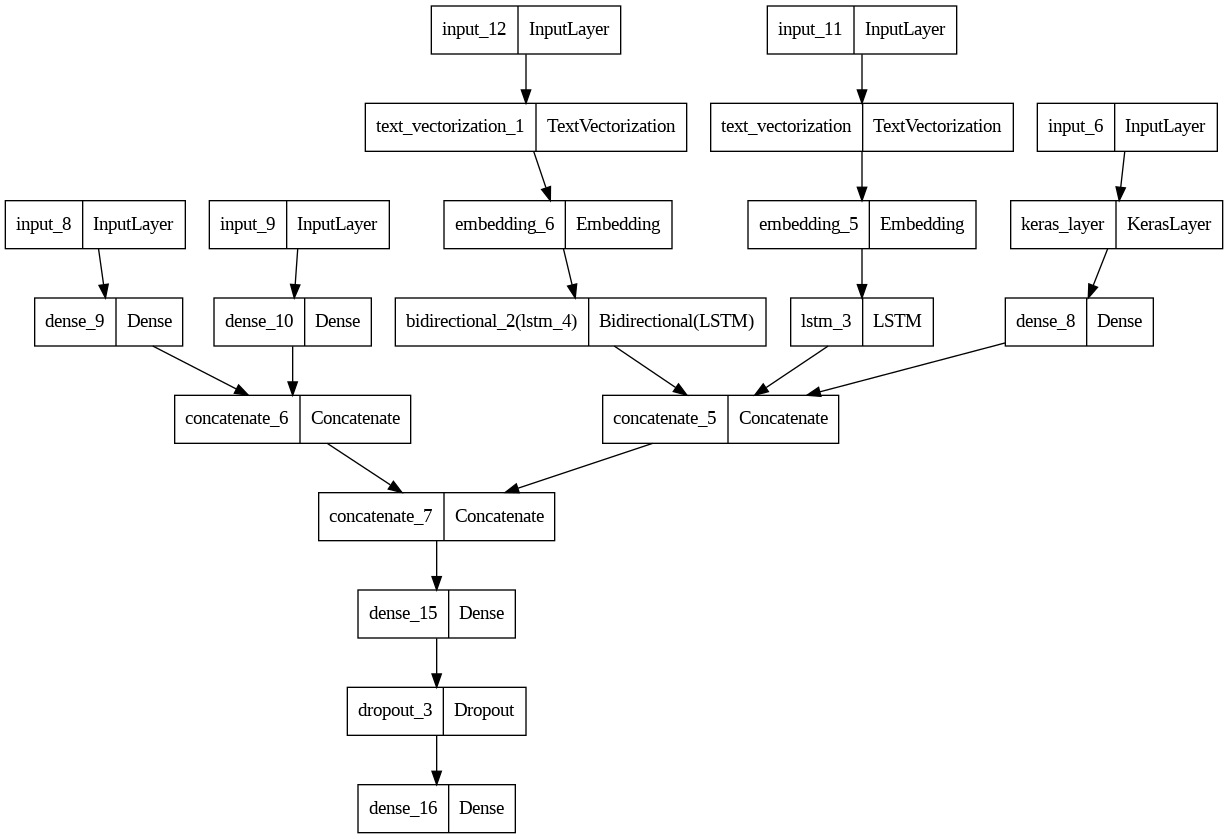

In [125]:
tf.keras.utils.plot_model(model_exp_2)

In [126]:
train_data_exp_2=tf.data.Dataset.from_tensor_slices((train_text, train_text, train_char, train_line_number_one_hot_encode, train_total_line_one_hot_encode))
train_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot_encode))
train_dataset_exp_2=tf.data.Dataset.zip((train_data_exp_2, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_data_exp_2=tf.data.Dataset.from_tensor_slices((test_text, test_text, test_char, test_line_number_one_hot_encode, test_total_line_one_hot_encode))
test_labels=tf.data.Dataset.from_tensor_slices((test_labels_one_hot_encode))
test_dataset_exp_2=tf.data.Dataset.zip((test_data_exp_2, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

validation_data_exp_2=tf.data.Dataset.from_tensor_slices((validation_text, validation_text, validation_char, validation_line_number_one_hot_encode, validation_total_line_one_hot_encode))
validation_labels=tf.data.Dataset.from_tensor_slices((validation_labels_one_hot_encode))
validation_dataset_exp_2=tf.data.Dataset.zip((validation_data_exp_2, validation_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_exp_2

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [127]:
model_exp_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

history_exp_2=model_exp_2.fit(train_dataset_exp_2,
                              epochs=5,
                              #steps_per_epoch=int(.1*len(train_dataset_exp_2)),
                              validation_data=(validation_dataset_exp_2),
                              validation_steps=int(.1*len(validation_dataset_exp_2)))

Epoch 1/5
945/945 [==============================] - 190s 192ms/step - loss: 1.0061 - accuracy: 0.7896 - val_loss: 0.9057 - val_accuracy: 0.8410
Epoch 2/5
945/945 [==============================] - 179s 190ms/step - loss: 0.8317 - accuracy: 0.9176 - val_loss: 0.8967 - val_accuracy: 0.8478
Epoch 3/5
945/945 [==============================] - 180s 191ms/step - loss: 0.7625 - accuracy: 0.9685 - val_loss: 0.9331 - val_accuracy: 0.8285
Epoch 4/5
945/945 [==============================] - 181s 191ms/step - loss: 0.7329 - accuracy: 0.9864 - val_loss: 0.9384 - val_accuracy: 0.8297
Epoch 5/5
945/945 [==============================] - 181s 192ms/step - loss: 0.7217 - accuracy: 0.9905 - val_loss: 0.9487 - val_accuracy: 0.8278


In [128]:
model_exp_2.evaluate(validation_dataset_exp_2)

5627/5627 [==============================] - 134s 24ms/step - loss: 0.9449 - accuracy: 0.8306


[0.9448610544204712, 0.8305598497390747]

In [129]:
pred_probs=model_exp_2.predict(validation_dataset_exp_2)
pred_probs

5627/5627 [==============================] - 130s 23ms/step


array([[0.05135227, 0.03826481, 0.03858459, 0.8270177 , 0.04478065],
       [0.06558679, 0.03796375, 0.70735216, 0.06260902, 0.12648828],
       [0.05410403, 0.04080711, 0.7737675 , 0.06089447, 0.0704269 ],
       ...,
       [0.03421482, 0.82956576, 0.03773611, 0.03977528, 0.05870804],
       [0.04066462, 0.82803327, 0.03982328, 0.03973625, 0.05174246],
       [0.02654919, 0.7627099 , 0.06798308, 0.08156639, 0.06119138]],
      dtype=float32)

In [130]:
y_preds=pred_probs.argmax(axis=1)
y_preds

array([3, 2, 2, ..., 1, 1, 1])

In [131]:
model_exp_2_results=calculate_metrics(validation_labels_encode, y_preds)
model_exp_2_results

{'Accuracy': 0.8305598755832038,
 'Precision': 0.8317889853218581,
 'Recall': 0.8305598755832038,
 'f1_score': 0.8306513959407564}

#**Conclusion**

In [132]:
import pandas as pd

results_df=pd.DataFrame({"Model_0_NaiveBais":model_0_results,
                         "Model_1_CNN_1-D":model_1_results,
                         "Model_2_TF":model_2_results,
                         "Model_3_CNN+Char_token":model_3_results,
                         "Model_4_Word+Char_token":model_4_results,
                         "Model_5_Positional+Word+Char_token":model_5_results,
                         "Model_exp_1_CNN+pos":model_exp_1_results,
                         "Model_exp_2_Word(Custom+TF)+char+pos":model_exp_2_results})
results_df=results_df.transpose()
results_df

,Accuracy,Precision,Recall,f1_score
Model_0_NaiveBais,0.676411,0.680566,0.676411,0.634930
Model_1_CNN_1-D,0.767657,0.767815,0.767657,0.766078
Model_2_TF,0.771456,0.779504,0.771456,0.772765
Model_3_CNN+Char_token,0.631188,0.657470,0.631188,0.630567
Model_4_Word+Char_token,0.759948,0.766436,0.759948,0.760111
Model_5_Positional+Word+Char_token,0.801589,0.800026,0.801589,0.799622
Model_exp_1_CNN+pos,0.711670,0.706239,0.711670,0.704306
Model_exp_2_Word(Custom+TF)+char+pos,0.830560,0.831789,0.830560,0.830651


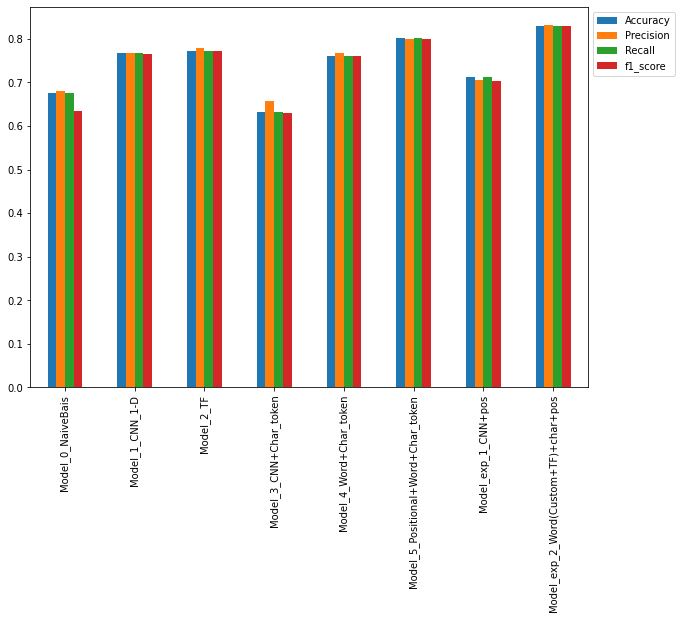

In [133]:
results_df.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1,1));

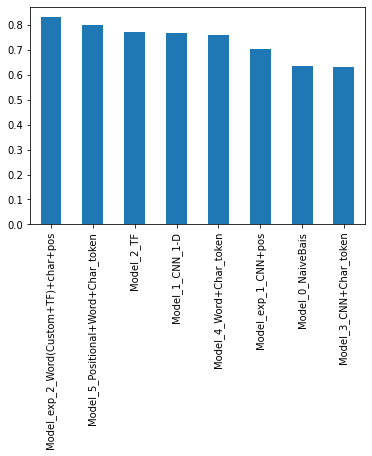

In [134]:
results_df.sort_values("f1_score", ascending=False)["f1_score"].plot(kind="bar");